## Feature Importance

Utilicemos Random Forest para ver la importancia de los features  
Importamos lo necesario para correr Random Forest

In [1]:
# Para ver los parametros que se utilizan
from pprint import pprint
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Usando XGBOOST

In [2]:
#Se obtiene de correr con XGBoost todos los features y max depth 10
filename = 'modelos/xgb_modelo_inicial.sav'

In [3]:
loaded_model = pickle.load(open(filename, 'rb'))

In [4]:
# [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
feature_important = loaded_model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)

El modelo se entreno con todos los features y get_dummies

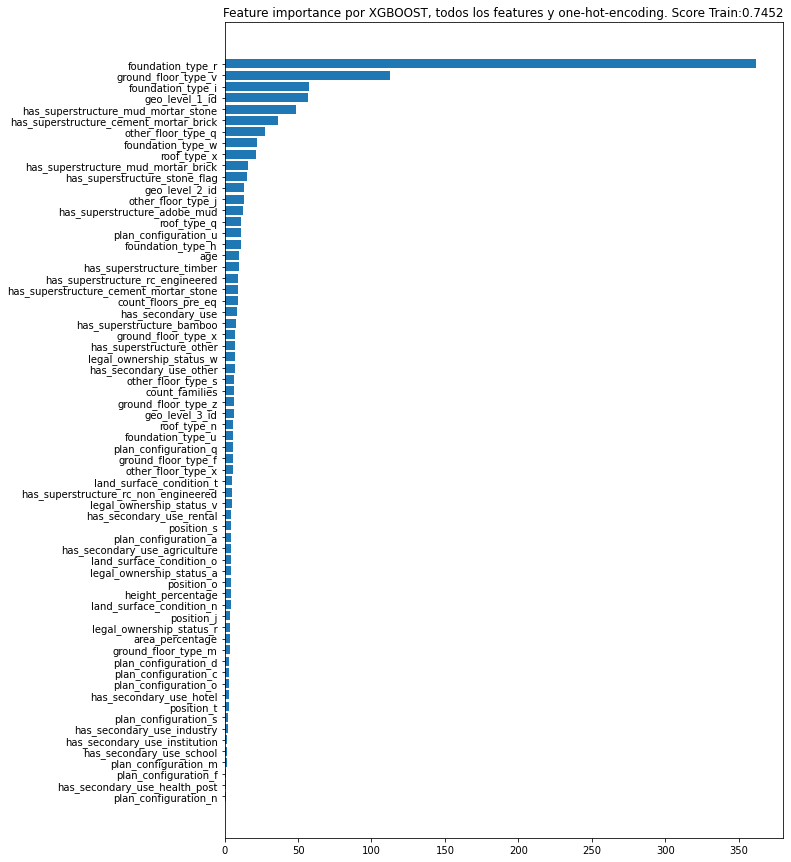

In [5]:
#Grafico de feature importance
fig, ax = plt.subplots(figsize=(10,15))
ax.barh(data.index,data['score'].values)
ax.set_title('Feature importance por XGBOOST, todos los features y one-hot-encoding. Score Train:0.7452')
plt.show()

## Conclusiones de Feature importance inicial

*  Las variantes has_secondary_use tienen muy poca importancia para XGBoost. Nos podemos quedar solo con la de has_secondary_use a secas.
*  Plan_configuration es el que lo sigue en menor importancia para el algoritmo. Considerar una transformación apropiada. "Si está alquilada->la cuidan menos->más deteriorada está->más riesgo de derrumbe ?)"
*  El resto es analizar columna por columna.

## Modelo después de transformaciones

* Drop has_sec_use variantes
* Drop plan_config
* winsorizing columnas age,area_percentage,height_percentage al 0.3,0.3,0.6 para el limite superior
* agregado de columnas mean_damage_grade para cada tipo de daño y para cada geo_level_id

In [18]:
# Se aplican las transformaciones de arriba
filename = 'modelos/xgb_modelo_7444.sav'

In [19]:
loaded_model = pickle.load(open(filename, 'rb'))

In [25]:
# Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
# Gain es muy interesante.
feature_important = loaded_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)

El modelo se entreno con todos los features y get_dummies

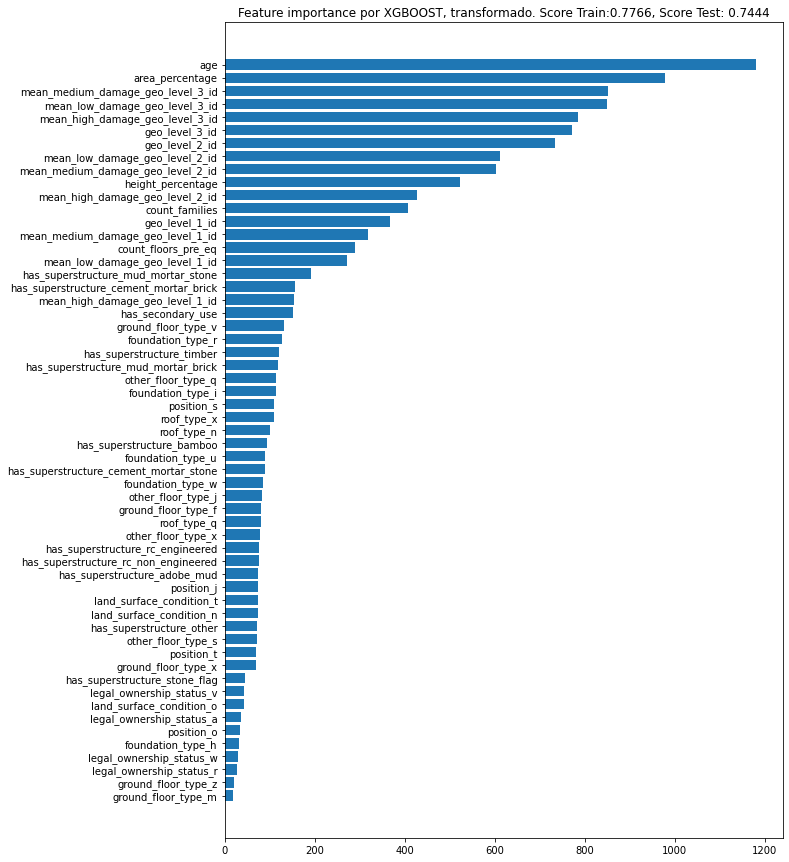

In [26]:
#Grafico de feature importance
fig, ax = plt.subplots(figsize=(10,15))
ax.barh(data.index,data['score'].values)
ax.set_title('Feature importance por XGBOOST, transformado. Score Train:0.7766, Score Test: 0.7444')
plt.show()

## Conclusiones
* Se puede ver como la mayoria de columnas aportan al modelo de manera significativa
* Hicimos un análisis estructural vs daños en el TP1. El modelo todavía no lo sabe. Podemos decírselo de la siguiente manera:
    * Podemos, para cada edificio, una probabilidad de que con esa configuracion estructural reciba un tipo de daño leve,medio o grave.  
      ¿Qué features podemos usar para determinar esta probabilidad/score? Según el análisis del TP1 tomaremos los features que indiquen  
      si la estructura es probable que reciba un daño leve,medio o grave. Los features son: 
      